# Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones

Autores: Matías Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer

In [2]:
URL_MELB_HOUSING_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_housing_filtered_df.csv"
URL_MELB_SUBURB_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_suburb_filtered_df.csv"

melb_housing_df = pd.read_csv(URL_MELB_HOUSING_FILTERED)
melb_suburb_df = pd.read_csv(URL_MELB_SUBURB_FILTERED)

In [3]:
melb_combim = melb_housing_df.join(melb_suburb_df, on="suburb_id")
melb_combim[:5]

,housing_price,housing_room_segment,housing_bathroom_segment,housing_land_size,housing_building_area,housing_type,housing_year_built,suburb_id,suburb_name,suburb_region_segment,suburb_council_area,suburb_rental_dailyprice
0,1480000.0,"(1, 2]","(0, 1]",202.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
1,1035000.0,"(1, 2]","(0, 1]",156.0,79.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
2,1465000.0,"(2, 3]","(1, 2]",134.0,150.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
3,850000.0,"(2, 3]","(1, 2]",94.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
4,1600000.0,"(3, 4]","(0, 1]",120.0,142.0,h,2014.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512


### Escalado de Variables Numéricas

In [4]:
numerical_cols = ["housing_price","housing_land_size","suburb_rental_dailyprice","housing_year_built","housing_building_area"]
standardscaler = StandardScaler()
melb_scaled = pd.DataFrame(standardscaler.fit_transform(melb_combim[numerical_cols]), columns= [label + '_scaled'for label in numerical_cols])
melb_scaled

,housing_price_scaled,housing_land_size_scaled,suburb_rental_dailyprice_scaled,housing_year_built_scaled,housing_building_area_scaled
0,0.951425,-0.219336,-0.145996,NaN,NaN
1,0.050450,-0.251387,-0.145996,-1.822263,-0.491710
2,0.921055,-0.266715,-0.145996,-1.822263,0.067492
3,-0.324113,-0.294585,-0.145996,NaN,NaN
4,1.194385,-0.276469,-0.145996,1.358374,0.004484
...,...,...,...,...,...
13201,0.475629,0.094199,-0.367630,0.437663,NaN
13202,0.042351,-0.128063,1.526336,0.828268,-0.066401
13203,0.323779,-0.056298,1.526336,0.884068,NaN
13204,3.016583,0.243303,1.526336,-1.264257,0.122625


### Encoding

### OneHotEncoder

#### Categóricas

In [5]:
categorical_cols = ["housing_room_segment", "housing_bathroom_segment", "housing_type", "suburb_name","suburb_region_segment", "suburb_council_area"]

encoder = OneHotEncoder(sparse=False)
encoder.fit(melb_combim[categorical_cols])
# We can inspect the categories found by the encoder
encoder.categories_

encoded_types = encoder.transform(melb_combim[categorical_cols])
encoded_types[:10]

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

#### Numéricas

In [6]:
numerical_cols_enc = ["housing_price_scaled","housing_land_size_scaled","suburb_rental_dailyprice_scaled"]

melb_numeric = melb_scaled[numerical_cols_enc].values
melb_numeric[:10]

array([[ 0.95142531, -0.21933637, -0.14599648],
       [ 0.05044974, -0.25138666, -0.14599648],
       [ 0.92105534, -0.26671506, -0.14599648],
       [-0.32411314, -0.29458487, -0.14599648],
       [ 1.19438501, -0.27646949, -0.14599648],
       [-0.1398687 , -0.23396802, -0.14599648],
       [ 1.75319233, -0.18937631, -0.14599648],
       [ 1.26727292, -0.18171211, -0.14599648],
       [-1.43767845, -0.36007894, -0.14599648],
       [ 0.17597892, -0.20679495, -0.14599648]])

In [7]:
matriz = np.hstack((encoded_types, melb_numeric))
matriz [:5]

array([[ 0.        ,  1.        ,  0.        , ...,  0.95142531,
        -0.21933637, -0.14599648],
       [ 0.        ,  1.        ,  0.        , ...,  0.05044974,
        -0.25138666, -0.14599648],
       [ 0.        ,  0.        ,  1.        , ...,  0.92105534,
        -0.26671506, -0.14599648],
       [ 0.        ,  0.        ,  1.        , ..., -0.32411314,
        -0.29458487, -0.14599648],
       [ 0.        ,  0.        ,  0.        , ...,  1.19438501,
        -0.27646949, -0.14599648]])

In [8]:
matriz.shape

(13206, 393)

### DictVectorizer

In [9]:
feature_cols = categorical_cols + numerical_cols_enc
feature_dict = list(melb_scaled.join(melb_combim)[feature_cols].T.to_dict().values())

vec = DictVectorizer()
feature_matrix = vec.fit_transform(feature_dict)
feature_matrix

<13206x393 sparse matrix of type '<class 'numpy.float64'>'
	with 118854 stored elements in Compressed Sparse Row format>

In [10]:
vec.get_feature_names()

['housing_bathroom_segment=(0, 1]',
 'housing_bathroom_segment=(1, 2]',
 'housing_bathroom_segment=(2, 8]',
 'housing_land_size_scaled',
 'housing_price_scaled',
 'housing_room_segment=(0, 1]',
 'housing_room_segment=(1, 2]',
 'housing_room_segment=(2, 3]',
 'housing_room_segment=(3, 4]',
 'housing_room_segment=(4, 10]',
 'housing_type=h',
 'housing_type=t',
 'housing_type=u',
 "suburb_council_area=['Banyule', 'Nillumbik']",
 "suburb_council_area=['Banyule', 'Whittlesea', 'Darebin']",
 "suburb_council_area=['Banyule']",
 "suburb_council_area=['Bayside', 'Glen Eira']",
 "suburb_council_area=['Bayside', 'Kingston']",
 "suburb_council_area=['Bayside', 'Unavailable']",
 "suburb_council_area=['Bayside']",
 "suburb_council_area=['Boroondara', 'Stonnington']",
 "suburb_council_area=['Boroondara', 'Whitehorse']",
 "suburb_council_area=['Boroondara']",
 "suburb_council_area=['Brimbank']",
 "suburb_council_area=['Cardinia']",
 "suburb_council_area=['Casey']",
 "suburb_council_area=['Darebin', 'B

### Imputación por KNN

In [17]:
#revisar
def mice_impute (df, column_names, neighbors):
    mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=neighbors, weights="uniform"))

    df.loc[:, [label + '_imputed'for label in column_names]] = mice_imputer.fit_transform(
        df[column_names])

In [18]:
def plot_imputers (df,col_name):
    mice_knn = df[col_name+"_imputed"].to_frame().rename(columns={col_name+"_imputed":col_name})
    mice_knn['Imputation'] = 'KNN over YearBuilt'
    
    melb_orig = df[col_name].dropna().to_frame()
    melb_orig['Imputation'] = 'Original'
    
    data = pd.concat([mice_knn, melb_orig])
    fig = plt.figure(figsize=(8, 5))
    g = seaborn.kdeplot(data=data, x=col_name, hue='Imputation')

#### Sin Escalar

In [19]:
at_least_onena= melb_combim['housing_year_built'].isna() | melb_combim['housing_building_area'].isna()
missing_values_indices= melb_combim[at_least_onena].index
melb_combim[at_least_onena]

,housing_price,housing_room_segment,housing_bathroom_segment,housing_land_size,housing_building_area,housing_type,housing_year_built,suburb_id,suburb_name,suburb_region_segment,suburb_council_area,suburb_rental_dailyprice,housing_year_built_imputed,housing_building_area_imputed
0,1480000.0,"(1, 2]","(0, 1]",202.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1995.0,121.0
3,850000.0,"(2, 3]","(1, 2]",94.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1995.0,121.0
5,941000.0,"(1, 2]","(0, 1]",181.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1995.0,121.0
8,300000.0,"(0, 1]","(0, 1]",0.0,NaN,u,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1995.0,121.0
10,700000.0,"(1, 2]","(1, 2]",0.0,NaN,u,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1995.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,1323000.0,"(3, 4]","(1, 2]",551.0,NaN,h,NaN,216,Wantirna South,Eastern Metropolitan,['Knox'],95.238095,1995.0,121.0
13196,970000.0,"(2, 3]","(1, 2]",674.0,NaN,h,NaN,216,Wantirna South,Eastern Metropolitan,['Knox'],95.238095,1995.0,121.0
13200,582000.0,"(2, 3]","(1, 2]",256.0,NaN,h,NaN,218,Westmeadows,Northern Metropolitan,['Hume'],123.084156,1995.0,121.0
13201,1245000.0,"(3, 4]","(1, 2]",652.0,NaN,h,1981.0,248,Wheelers Hill,South-Eastern Metropolitan,['Monash'],109.742268,1981.0,178.5


In [20]:
mice_impute(melb_combim,['housing_year_built', 'housing_building_area'], 2 )

C:\Users\USUARIO\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


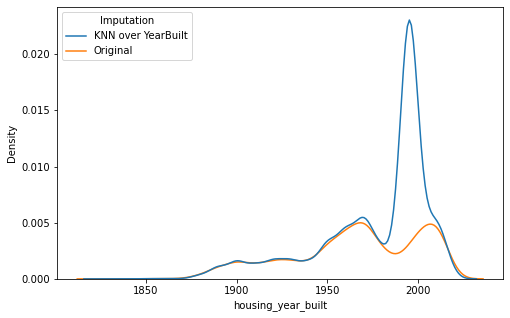

In [23]:
plot_imputers(melb_combim, 'housing_year_built')

In [21]:
melb_combim[:3]

,housing_price,housing_room_segment,housing_bathroom_segment,housing_land_size,housing_building_area,housing_type,housing_year_built,suburb_id,suburb_name,suburb_region_segment,suburb_council_area,suburb_rental_dailyprice,housing_year_built_imputed,housing_building_area_imputed,housing_year_built_imputed,housing_building_area_imputed
0,1480000.0,"(1, 2]","(0, 1]",202.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1995.0,121.0,1995.0,121.0
1,1035000.0,"(1, 2]","(0, 1]",156.0,79.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1900.0,79.0,1900.0,79.0
2,1465000.0,"(2, 3]","(1, 2]",134.0,150.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512,1900.0,150.0,1900.0,150.0


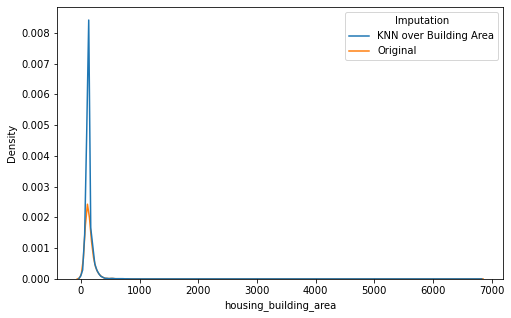

In [22]:
#Este estaba OK
mice_build_area_knn = melb_combim["housing_building_area_imputed"].to_frame().rename(columns={"housing_building_area_imputed":"housing_building_area"})
mice_build_area_knn['Imputation'] = 'KNN over Building Area'
melb_build_area_orig = melb_combim["housing_building_area"].dropna().to_frame()
melb_build_area_orig['Imputation'] = 'Original'
data = pd.concat([mice_build_area_knn, melb_build_area_orig])
fig = plt.figure(figsize=(8, 5))
g = seaborn.kdeplot(data=data, x="housing_building_area", hue='Imputation')

#### Con Escalado